<a href="https://colab.research.google.com/github/abdulsamadkhan/AlignmentTuning/blob/main/RewardTrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reward Modeling using `trl` library
In this tutorial, you'll step into the role of a machine learning engineer at a large tech company. Your goal is to integrate a powerful large language model (LLM) into AI-driven products that require understanding complex instructions, generating high-quality responses, and improving automated customer support.

But choosing an off-the-shelf LLM isn’t enough. To make it truly effective, you'll need to fine-tune it so that it not only performs well technically but also aligns with your company’s values and objectives. That’s where reward models come in.

In this hands-on walkthrough, you’ll learn how to:

1. Set up your development environment for training reward models using the trl library from Hugging Face.

2. Define custom reward functions that reflect the behaviors and priorities your LLM should follow.

3. Train a reward model to score outputs based on these preferences.

4. Use reinforcement learning to fine-tune the LLM so it consistently produces better, more aligned responses.

By the end of this tutorial, you’ll understand how to guide LLM behavior with reward models and apply these techniques to real-world AI applications. Let’s get started!

## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    </ul>
    <li><a href="#Setup">Setup</a></li>
    <ul>
        <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
        <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
        <li><a href="#Defining-helper-functions">Defining helper functions</a></li>
    </ul>
    <li><a href="#Dataset">Data set</a></li>
    <ul>
        <li><a href="#Purpose">Purpose</a></li>
        <li><a href="#Applications">Applications</a></li>
        <li><a href="#Dataset-features">Data set features</a></li>
    </ul>
    <li><a href="#Model-and-tokenizer-Setup">Model and tokenizer setup</a></li>
    <li><a href="#Preprocessing">Preprocessing</a></li>
    <ul>
        <li><a href="#LoRA-configuration">LoRA configuration</a></li>
        <li><a href="#Training-arguments">Training arguments</a></li>
        <li><a href="#Reward-Trainer">Reward trainer</a></li>
    </ul>
    <li><a href="#Evaluating-the-model">Evaluating the model</a></li>
    <li><a href="#Exercise">Exercise</a></li>
</ol>


# Objectives
By the end of this tutorial, you will be able to:
- Grasp the fundamentals of how reward modeling guides language model behavior in machine learning.

- Work with real-world datasets by cleaning and preparing them for use in reward-based training tasks.

- Configure a GPT-2 model specifically for sequence classification workflows.

- Process and tokenize text data to make it compatible with transformer-based models.

- Assess model performance by comparing and ranking pairs of generated responses.

- Apply both preprocessing and evaluation methods to various data segments.

- Deepen your understanding of key principles behind transformers and how they relate to reward learning.

- Use special tokens in the tokenizer and adjust model settings to accommodate them effectively.

# Setup
## Installing required libraries



In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0  transformers==4.31.0 trl==0.5.0
!pip install -q sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56

## Importing required libraries


In [2]:
import json
from datasets import load_dataset, DatasetDict
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, TrainingArguments
from peft import LoraConfig, TaskType
from transformers import TrainingArguments
from trl import RewardTrainer



## Defining helper functions


In [3]:
def save_to_json(data, file_path):
    """
    Save a dictionary to a JSON file.

    Args:
        data (dict): The dictionary to save.
        file_path (str): The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")


def load_from_json(file_path):
    """
    Load data from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data loaded from the JSON file.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data


## Data set

For this turorial we will use the Dahoas/synthetic-instruct-gptj-pairwise data set. In this dataset each data point consist of prompt with a pair of Good and Bad response. The main purpose is to train models to distinguish between better and worse responses.




In [4]:
# Load the Dahoas/synthetic-instruct-gptj-pairwise dataset
dataset = load_dataset("Dahoas/synthetic-instruct-gptj-pairwise")
# Display the dataset
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

(…)-00000-of-00001-1e5d57b93c448e7a.parquet:   0%|          | 0.00/18.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33143 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 33143
    })
})


### Data set features

To get a better understanding of the data set, let's inspect a few samples. each data point is structured as.

`Prompt:` The input text or question provided to the model to generate a response.

`Chosen:` The response that is considered better or more appropriate for the given prompt.

`Rejected:` The response that is deemed less suitable or lower in quality compared to the chosen one.


In [5]:
for i in range(10):
    print('prompt')
    print(dataset["train"][i]['prompt'],'\n')

    print('chosen')
    print(dataset[ 'train'][i]['chosen'],'\n')

    print('rejected')
    print(dataset[ 'train'][i]['rejected'],'\n')
    print('**********************************************\n')

prompt
I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs. 

chosen
Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients. 

rejected
How do I store a

## Model and tokenizer setup
In this section, you set up the tokenizer and the model for training. You can use the GPT-2 model for sequence classification, which helps in determining the quality of responses.

Next, specify the model name or path as "gpt2". To initialize the tokenizer and model, use `GPT2Tokenizer.from_pretrained` and `GPT2ForSequenceClassification.from_pretrained`, respectively, with `num_labels` set to 1 for ranking (a numerical score value). To handle padding, set the `pad_token` of the tokenizer to be the same as the `eos_token` (end-of-sequence token). Similarly, configure the model to use the `eos_token_id` as the `pad_token_id`. This setup ensures that the tokenizer and model are correctly initialized and prepared for sequence classification tasks with GPT-2.


In [6]:
# Define the model name or path
model_name_or_path = "gpt2"

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path, use_fast=True)
model = GPT2ForSequenceClassification.from_pretrained(model_name_or_path, num_labels=1)

# Add special tokens if necessary
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# Define the maximum length
max_length = 1024

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next, preprocess the data set for training. Then combine the prompt with the chosen and rejected responses into a format suitable for input into the model. This process helps create clear input-output pairs for the model to learn from.

`Lambda Function`: Define a lambda function `get_res` that takes the data set and a response type (chosen or rejected) and combines the prompt with the respective response. Each entry is formatted as a dialogue between "Human" and "Assistant".


In [7]:
def get_format(dataset, res):
    result = []
    for prompt, resp in zip(dataset["train"]["prompt"], dataset["train"][res]):
        formatted = f"\n\nHuman: {prompt}\n\nAssistant: {resp}"
        result.append(formatted)
    return result


`Chosen Samples`: Apply the `get_res` function to create a list of chosen samples.

`Rejected Samples`: Similarly, create a list of rejected samples using the same function.

After applying the function,  you get the following results.


In [8]:
chosen_samples=get_format( dataset,'chosen')
rejected_samples=get_format( dataset,'rejected')
print('chosen',chosen_samples[0])
print('rejected',rejected_samples[0])

chosen 

Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.
rejected 

Huma

To facilitate the training process, create new columns in the data set that combine the prompt with chosen and rejected responses. This combination helps in evaluating the responses in a structured dialogue format.

**Function definition**: Define a function `add_combined_columns` that takes an example (a single data point) and adds two new columns:
- `prompt_chosen`: Combines the `prompt` with the `chosen` response in the same labeled format.
- `prompt_rejected`: Combines the `prompt` with the `rejected` response in the same labeled format.

**Apply function**: The `map` method is used to apply this function to each example in the training split of the data set. This method iterates over all the examples and modifies them in place.


In [9]:
# Define a function to combine 'prompt' with 'chosen' and 'rejected' responses
def add_combined_columns(example):
    # Combine 'prompt' with 'chosen' response, formatting it with "Human:" and "Assistant:" labels
    example['prompt_chosen'] = "\n\nHuman: " + example["prompt"] + "\n\nAssistant: " + example["chosen"]

    # Combine 'prompt' with 'rejected' response, formatting it with "Human:" and "Assistant:" labels
    example['prompt_rejected'] = "\n\nHuman: " + example["prompt"] + "\n\nAssistant: " + example["rejected"]

    # Return the modified example
    return example

# Apply the function to each example in the 'train' split of the dataset
dataset['train'] = dataset['train'].map(add_combined_columns)

Map:   0%|          | 0/33143 [00:00<?, ? examples/s]

When using pretrained transformers for classification tasks, understanding the maximum sequence length supported by the model is crucial, as pretrained transformers have a fixed maximum token length, for example, GPT-2 has 1024 tokens. Inputs longer than this are truncated, potentially losing important information. So a function is written to determine the max length.


In [10]:
get_max_len= lambda samples: max([len(sample) for sample in samples])
get_max_len

<function __main__.<lambda>(samples)>

In [11]:
print("rejected samples length",get_max_len(rejected_samples))
print("chosen samples length",get_max_len(chosen_samples))

rejected samples length 5011
chosen samples length 3167


Sometimes, you might want to identify samples shorter than a specified maximum length. This can be useful for filtering or handling special cases during preprocessing.

The lambda function `find_short` takes a data set and a maximum length (`max_length`) as input. It uses a list comprehension to iterate over each example in the data set, enumerating both the index and the (chosen, rejected) pair. It zips `prompt_chosen` and `prompt_rejected` to pair each chosen response with its corresponding rejected response. For each pair, it checks if the length of either `chosen` or `rejected` is less than the specified `max_length`. If the condition is met, the index of that pair is included in the resulting list. The resulting list contains the index of all examples where either `prompt_chosen` or `prompt_rejected` is shorter than the specified `max_length`.


In [12]:
find_short = lambda dataset, max_length: [
    i for i, (chosen, rejected) in enumerate(zip(dataset['prompt_chosen'], dataset['prompt_rejected']))
    if len(chosen) < max_length or len(rejected) < max_length
]

To ensure that your data set only includes samples that meet the required length criteria, filter out any samples that are shorter than the specified `max_length`. This step is important for maintaining consistency in the input data for the model.

Now, use the GPT-2 model for classification with a max length of 1024. First, set the maximum length (`max_length`) to 1024. The `find_short` function is then called with the training data set (`dataset['train']`) and this maximum length as arguments to find indices of examples where either `prompt_chosen` or `prompt_rejected` is shorter than the specified `max_length`. The resulting index (`subset_indices`) is used to create a subset of the training data set by selecting only the examples at these indices. The training data set (`dataset['train']`) is updated to this subset, and the `subset_indices` are returned or printed.


In [13]:
max_length=1024
subset_indices=find_short (dataset['train'], max_length)
dataset['train'] = dataset['train'].select(subset_indices)
subset_indices[0:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


 The ```preprocess_function``` tokenizes the ```prompt_chosen``` and ```prompt_rejected``` keys, which are crucial for the RewardTrainer. The ```chosen``` key represents the preferred responses, while the ```rejected``` key represents the less preferred responses.
 Tokenizing these keys allows the model to process and understand the differences between high-quality and low-quality responses. By providing both ```chosen``` and ```rejected``` inputs, the RewardTrainer can learn to distinguish and prioritize better responses, which is essential for training models to follow instructions effectively.


In [14]:
# Define a preprocessing function to tokenize the 'prompt_chosen' and 'prompt_rejected' keys
def preprocess_function(examples):
    # Tokenize the 'prompt_chosen' text with truncation and padding to the maximum length
    tokenized_chosen = tokenizer(examples['prompt_chosen'], truncation=True, max_length=max_length, padding="max_length")

    # Tokenize the 'prompt_rejected' text with truncation and padding to the maximum length
    tokenized_rejected = tokenizer(examples['prompt_rejected'], truncation=True, max_length=max_length, padding="max_length")

    # Return the tokenized inputs as a dictionary
    return {
        "input_ids_chosen": tokenized_chosen["input_ids"],  # Token IDs for 'chosen' responses
        "attention_mask_chosen": tokenized_chosen["attention_mask"],  # Attention masks for 'chosen' responses
        "input_ids_rejected": tokenized_rejected["input_ids"],  # Token IDs for 'rejected' responses
        "attention_mask_rejected": tokenized_rejected["attention_mask"],  # Attention masks for 'rejected' responses
    }


The `input_ids_chosen` and `input_ids_rejected` fields contain the token IDs for the `chosen` and `rejected` responses, respectively, which are the numerical representations of the text used by the model. The `attention_mask_chosen` and `attention_mask_rejected` fields contain the attention masks for the `chosen` and `rejected` responses, respectively, which indicates tokens that should be attended to (1) and should ignore (0). These fields are crucial for the `RewardTrainer` because they provide the necessary tokenized inputs and attention masks for both the preferred and less preferred responses. By comparing the token IDs and attention patterns of the `chosen` and `rejected` responses, the `RewardTrainer` can distinguish between high- and low-quality responses, thereby improving the model's ability to prioritize better responses in instruction-following tasks.

You can apply the ```reprocess_function``` to one sample:


In [15]:
example=preprocess_function(dataset['train'][0])
example.keys()

dict_keys(['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'])

Now, create a dictionary with 'chosen' and 'rejected' samples from the training data set. This dictionary is created to make it easier to validate the model later.


In [16]:
train_str={'chosen': [sample for sample in dataset['train'] ['prompt_chosen']], 'rejected':[sample for sample in dataset['train'] ['prompt_rejected']]}

The code applies the preprocess_function to each example in the training data set using the map method, which tokenizes the ```prompt_chosen``` and ```prompt_rejected``` texts. The `batched = True` parameter allows the function to process multiple examples at once, improving efficiency. Additionally, the `remove_columns` parameter specifies a list of columns (```prompt```, ```chosen```, ```rejected```, ```prompt_chosen```, ```prompt_rejected```) to be removed from the data set after processing. This ensures that only the tokenized inputs and attention masks generated by `preprocess_function` are retained, simplifying the data set structure and making it more suitable for model training and validation.


In [17]:
dataset['train'] = dataset['train'].map(preprocess_function, batched=True, remove_columns=['prompt',"chosen", "rejected",'prompt_chosen', 'prompt_rejected'])

Map:   0%|          | 0/33043 [00:00<?, ? examples/s]

The only columns left are the tokens and masks indexes.


In [18]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'],
        num_rows: 33043
    })
})


Finally, split the data set into training and testing data set. FOr this purpose I can use all the data, but for the interest of tutotrail I will use 15% of the overall data for training and 5% for the test.


In [19]:
from datasets import DatasetDict

# Step 1: Get 20% of the original dataset
small_split = dataset['train'].train_test_split(test_size=0.20, seed=42)

# Step 2: From that 20%, split 75% as train (i.e., 15% of original) and 25% as test (i.e., 5% of original)
small_20_split = small_split['test'].train_test_split(test_size=0.25, seed=42)

# Step 3: Create the new DatasetDict
small_dataset_dict = DatasetDict({
    'train': small_20_split['train'],  # 15% of original
    'test': small_20_split['test']     # 5% of original
})


In [20]:
small_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'],
        num_rows: 4956
    })
    test: Dataset({
        features: ['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'],
        num_rows: 1653
    })
})

## LoRA configuration

Now that the training data set is ready, you use the pretrain transformer model to start training. However, it is advisable to use a more efficient LoRA configuration for the model. Now, define the LoRA configuration and training arguments.

First, initialize a `LoraConfig` configuration for low-rank adaptation (LoRA) in a sequence classification task. The configuration is created by using the `LoraConfig` class from the `peft` library and specifies several parameters:

- **task_type=TaskType.SEQ_CLS**: Specifies the type of task, that is, the sequence classification for this lab.
- **inference_mode=False**: Indicates that the configuration is for training mode rather than inference.
- **r=8**: Sets the rank of the LoRA matrices.
- **lora_alpha=32**: Sets the alpha value for scaling the LoRA matrices.
- **lora_dropout=0.1**: Specifies the dropout rate for the LoRA layers, helping to prevent overfitting.
- **target_modules=["attn.c_attn", "attn.c_proj"]**: Lists the specific attention layers in the model that will be adapted using LoRA. This includes the `attn.c_attn` and `attn.c_proj` modules.

This configuration is useful for applying LoRA to the specific parts of the model, enabling efficient fine-tuning by adapting only a subset of the model parameters.

In [21]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["attn.c_attn", "attn.c_proj"]  # Target attention layers
)

## Training arguments

Define the training arguments by using the `TrainingArguments` class from the `transformers` library. These arguments configure various aspects of the training process:

- **per_device_train_batch_size=3**: Sets the batch size per device (GPU/CPU) to 3
- **num_train_epochs=3**: Specifies the number of training epochs and is set to 3
- **gradient_accumulation_steps=8**: Accumulates gradients over 8 steps before performing a backward/update pass, effectively increasing the batch size
- **learning_rate=1.41e-5**: Sets the learning rate for the optimizer to 1.41e-5
- **output_dir="./model_output3"**: Specifies the directory where the model checkpoints and other outputs are saved
- **logging_steps=10**: Logs training progress every 10 steps
- **evaluation_strategy="steps"**: Sets the evaluation strategy to evaluate the model at regular steps
- **eval_steps=500**: Evaluates the model every 500 steps
- **save_steps=500**: Saves the model checkpoint every 500 steps
- **save_total_limit=2**: Limits the number of saved checkpoints to 2, deleting older checkpoints to save space

These arguments configure the training loop, including batch size, learning rate, logging, evaluation, and checkpoint-saving strategies.

In [22]:
# Define training arguments

training_args = TrainingArguments(
    per_device_train_batch_size=3,  # Set to 3
    num_train_epochs=3,  # Set to 3
    gradient_accumulation_steps=8,
    learning_rate=1.41e-5,
    output_dir="./model_output3",
    logging_steps=10,
   # eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,
)

### RewardTrainer

The `RewardTrainer` is a specialized trainer that is designed to train models with a reward signal. This is often used in reinforcement learning scenarios where the model learns to optimize for better responses. It is initialized with several parameters:

- **model**: The model to be trained
- **args**: The training arguments. Typically, an instance of `TrainingArguments`
- **tokenizer**: The tokenizer used to process the text inputs
- **train_dataset**: The training data set
- **eval_dataset**: The evaluation data set
- **peft_config**: The configuration for LoRA

The `RewardTrainer` orchestrates the training process, handling tasks such as batching, optimization, evaluation, and saving model checkpoints. It is particularly useful for training models that need to learn from feedback signals, improving their ability to generate high-quality responses.


In [24]:
# Initialize RewardTrainer
trainer = RewardTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=small_dataset_dict['train'],
    eval_dataset=small_dataset_dict['test'],
    peft_config=peft_config,
)

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora.py:299: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/reward_trainer.py:123: UserWarning: When using RewardDataCollatorWithPadding, you should set `max_length` in the RewardTrainer's init it will be set to `512` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/reward_trainer.py:134: UserWarning: When using RewardDataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


>Note: You can safely ignore the above warning.


#### Train, Save, and Evaluate the Model

Now that everything is set up, it's time to train the model using the `RewardTrainer`. This step will help the model learn how to better score responses based on the training data.

---

#### 1. **Train the Model**

To start training, simply use:

```python
trainer.train()
```
This line starts the training process. The model looks at examples in the training dataset and updates its internal parameters to improve how it ranks good vs. bad responses.
#### 2. Save the Trained Model
Once training is finished, you can save the model to a folder for later use:
```
trainer.save_model(output_dir)
```
#### 3. Evaluate the Model
To check how well the model performs, use the evaluate() method:
```
metrics = trainer.evaluate()
print(metrics)
```

In [26]:
output_dir="./model_output3"

# # Train the model
#trainer.train()

# # Save the model
#trainer.save_model(output_dir)

# # Evaluate the model
metrics = trainer.evaluate()
print(metrics)

model.config.save_pretrained("./backup")

{'eval_loss': 0.21613489091396332, 'eval_accuracy': 0.9213551119177253, 'eval_runtime': 305.7441, 'eval_samples_per_second': 5.406, 'eval_steps_per_second': 0.677, 'epoch': 2.99}



## Evaluating the model
The `RewardTrainer` uses a method called pairwise comparison to test how well the model can tell the difference between good and bad responses. It is shown two responses at a time—one marked as better and the other as worse. The model looks at both and gives each one a score based on what it has learned. These scores (called logits) show how much the model "likes" each response. The one with the higher score is picked as the better response, showing that the model can choose higher-quality answers

Next, plot the loss. You can see it converges nicely.

Run the below code to unzip the file.


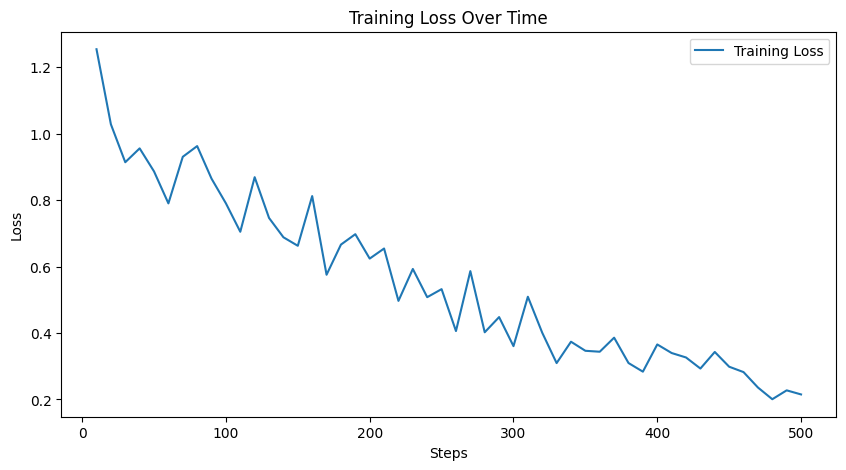

In [27]:
from matplotlib import pyplot as plt
import json
log_file = f"model_output3/checkpoint-500/trainer_state.json"

# Read the log file
with open(log_file, 'r') as f:
    logs = json.load(f)

# Extract training loss values
steps = []
losses = []
for log in logs["log_history"]:
    if "loss" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

The code first tokenizes `text1` by using the tokenizer, converting it into the format required by the model. The `tokenizer` function processes the input text into tensors with padding and truncation to ensure uniform input length, up to a maximum of 512 tokens. The `inputs` are then moved to the GPU, if available, for faster computation. The `model` is also transferred to the GPU. The inputs dictionary is updated to move all of its items to the device (GPU or CPU).

The model is then used to generate outputs without computing gradients (`torch.no_grad()`), making the inference process faster and more memory-efficient. The score, the logits from the model's output, are extracted, representing the raw predictions. These logits are then passed through a sigmoid function to convert them into probabilities, which can be interpreted as the model's confidence in the projections. The resulting probabilities are printed or returned for further use.


In [28]:
text1=train_str['chosen'][0]
print(text1)



Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.


In [29]:
inputs = tokenizer(text1, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Move inputs to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
logit_1 = outputs.logits
print("Score :",logit_1 )

Score : tensor([[7.0020]], device='cuda:0')


Do the same for the rejected sample


In [30]:
text2=train_str['rejected'][0]
print(text2)



Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: How do I store a bagels for eating at a later date?


 You can place the bagels in an airtight container and reheat them in the microwave.  Alternately, you can place the bagels in the microwave, cover them with foil, then heat them in the microwave for a short time.


In [31]:
inputs = tokenizer(text2, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Move inputs to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
logit_2 = outputs.logits
print("Score :",logit_2 )

Score : tensor([[3.1895]], device='cuda:0')


To demonstrate how pairwise comparison is useful for evaluating and ranking responses based on the model's predictions, use the following code that performs a pairwise comparison. To determine which of the two responses, represented by `logit_1` and `logit_2`, is preferred, compare the logits, which are raw scores output by the model that indicate the quality of the responses. If `logit_1` is greater than `logit_2`, the first response (`text1`) is selected as the better response, and the second response (`text2`) is rejected, printing both the selected and rejected responses along with their respective scores. Conversely, if `logit_2` is greater or equal, the second response (`text2`) is selected, and the first response (`text1`) is rejected, again printing both responses and their scores.


In [32]:
if logit_1 > logit_2:
    print("--------selected---------")
    print(text1, logit_1.detach().item())
    print("--------rejected---------")
    print(text2, logit_2.detach().item())
else:
    print("selected ")
    print(text2, logit_2.detach().item())
    print("rejected")
    print(text2, logit_2.detach().item())

--------selected---------


Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrien

Now, convert the process of tokenizing, generating a score, and comparing the outputs into two separate functions. The first function handles tokenizing the text and generating the model's output scores, while the second function performs the pairwise comparison of these scores. Structuring the code this way ensures that the process is modular and easier to manage, facilitating a clear and efficient workflow for evaluating and selecting the better response based on the model's predictions.


In [33]:
# Function to make a prediction and get the logits
def predict_and_get_logits(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform the forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the logits from the outputs
    logits = outputs.logits.squeeze().item()  # Assuming binary classification and batch size of 1

    return logits

In [34]:
# Function to compare two texts
def compare_texts(text1, text2):
    logit1 = predict_and_get_logits(text1)
    logit2 = predict_and_get_logits(text2)

    if logit1 > logit2:
        print("selected---------")
        print(text1, f"score: {logit1}")

        return text1
    else:
        print("selected---------")
        print(text2,  f"score: {logit2}")

        return text2

Finally,  evaluate the performance of a model by using a pairwise comparison approach over a subset of the data set. It begins by defining N, the number of samples to evaluate, and initializes a counter `correct_selections` to keep track of how many times the model correctly identifies the preferred response. The code then iterates over the first N pairs of chosen and rejected responses from the training data set (`train_str['chosen']` and `train_str['rejected']`).


In [35]:
# Define the number of samples to evaluate
N = 500

# Initialize a counter for correct selections
correct_selections = 0

# Iterate over the first N pairs of chosen and rejected responses
for chosen, rejected in zip(train_str['chosen'][0:N], train_str['rejected'][0:N]):
    # Print the chosen response for reference
    print("Chosen Response:\n", chosen)

    # Use the compare_texts function to determine which response is better
    selected_text = compare_texts(chosen, rejected)

    # Check if the selected text is the chosen response
    if selected_text == chosen:
        correct_selections += 1

# Calculate the accuracy as the ratio of correct selections to the total number of samples
accuracy = correct_selections / N

# Print the accuracy
print("Accuracy:", accuracy)

Streaming output truncated to the last 5000 lines.

Human: How can I get over a fear of public speaking.

Assistant: The best way to get over a fear of public speaking is to start by focusing on the content of your presentation. Make sure you know the material well and practice your presentation ahead of time. Also, it can help to imagine your audience in a positive light, think of them as excited to hear what you have to say. Finally, take deep breaths and focus on speaking slowly and clearly to help you stay calm. score: 7.201358795166016
Chosen Response:
 

Human: How can I select the best produce at the store.

Assistant: The best way to select produce at the store is to look for items that are brightly colored and free from bruises, blemishes, or wilting leaves. Check for firm texture and check to see if the produce has been kept in a temperature-controlled environment prior to your visit. It is also important to look for produce that is in season as it will typically provide the 